## K-Armed Bandits example
### Definitions
$q_*(a)=E[R_t|A_t=a]$: Value of an arbitrary action $a$ is the expected reward given that $a$ is selected <br/>
$a:$ Set of all possible actions <br/>
$Q_i(a):$ Action-value estimates at step i for any action <br/>
$A_i:$ Action taken at step i <br/>
$R_i:$ Reward obtained for action A_i <br/>

### Sample averages

We need to approximate $q_*(a)$, a simple way to do this is to average the rewards obtained so far for each action, this is called the sample-average method. $Q_t(a)$ converges to $q_*(a)$ for large numbers.  

$Q_t(a) = \frac{\text{sum of rewards when a taken prior to t}}{\text{sum of times a taken prior to t}} = \frac{\sum_{i=1}^{t-1}R_i \cdot \mathrm{I}_{A_i=a}}{\sum_{i=1}^{t-1}\mathrm{I}_{A_i=a}}$ 

Where $\mathrm{I} = 1$ if $A_i = a$ and $0$ if not, for all $a$. 

#### Incremental implementation 

The calculation of $Q_t(a)$ as written above is not computationally efficient since we need to recover all the values prior to $t$, a faster implementation would be to write $Q$ for a single action after it has been selected $n-1$ times as:

$Q_n = \frac{\sum_{i=1}^{n-1}R_i}{n-1}$

$R_i$ is the reward recieved after the $i$-th selection of the action. Then it is possible to write the incremental formula given $Q_n$ and $R_n$:

$Q_{n+1} = \frac{1}{n}\sum_{i=1}^{n}R_i =\frac{1}{n}\left(R_n + \frac{n-1}{n-1}\sum_{i=1}^{n-1}R_i\right) = \frac{1}{n}\left(R_n + (n-1)Q_n\right) = Q_n + \frac{1}{n}\left(R_n-Q_n\right)$

The equation above only needs the information regarding the previous reward and sample average of the last action taken.
### Greedy policy
Now that we have a way to estimate the values of every action, we need a policy to select which action to take at time step $t$ given the previous values. A greedy approach would be to choose the highest value.

$A_t = argmax_a Q_t(a)\rightarrow$Always exploits, no exploration.
#### $\epsilon$-Greedy
Choose action $A_t$ (greedily) with probability $1-\epsilon$, and choose randomly from all possible actions with probability $\epsilon$. This allows to exploit most of the time, while having room for exploration.

An advantage of this method is that $Q_{t\rightarrow \infty}(a) = q_*(a)$ for all $a$, because every action has the possibility ($\epsilon$) of being chosen, and the probability of choosing the optimal policy is $1-\epsilon$.

### Exercise 2.1 
If $\epsilon = 0.5$ there is a $1-0.5$ chance of choosing greedily, however, if the selection is random, the greedy option is still available.

$P(\text{greedy}) = P(\text{greedy}|\text{greed policy})P(\text{greed policy}) + P(\text{greedy}|\text{random policy})P(\text{random policy})$

$= 1\cdot (1-\epsilon) + \frac{1}{|a|}\cdot \epsilon = 0.5+\frac{0.5}{|a|}$

Where $|a|$ is the number of actions available.

### Exercise 2.2

In [1]:
import numpy as np
import time
import random
np.seterr(divide='ignore', invalid='ignore')

import tensorflow_probability as tfp
import tensorflow as tf
tf.enable_eager_execution()

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

actions = np.array([1,2,3,4], dtype = np.float32) # possible actions ("a")
action_seq = np.array([1,2,2,2,3], np.float32) # Actions taken (A_i)
rewards = np.array([1,1,2,2,0], np.float32) #Rewards gained (R_i)
Q = np.zeros(actions.shape[0]) #Estimated values

def sample_avg(actions, action_seq, rewards):
    steps = range(1, len(action_seq)+1)
    q = np.zeros((len(steps)+1, len(actions)))
    for t in steps:
        num = np.array([rewards[:t][action_seq[0:t]==i] for i in actions])
        num = np.array([np.sum(num[i]) for i in range(len(num))])
        den = np.sum(np.array([action_seq[0:t]==i for i in actions]), axis = 1)
        q[t,:]=np.where(den == 0, den, num/den)
    return q
q = sample_avg(actions, action_seq, rewards)
print(q, action_seq)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

[[0.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [1.         1.         0.         0.        ]
 [1.         1.5        0.         0.        ]
 [1.         1.66666667 0.         0.        ]
 [1.         1.66666667 0.         0.        ]] [1. 2. 2. 2. 3.]


Step 1: Greedy (breaking ties randomly) or $\epsilon$, all actions have same Q.<br/>
Step 2: $\epsilon$, didn't choose highest Q action.<br/>
Step 3: Greedy (breaking ties randomly), options 1 and 2 have the same rewards.<br/>
Step 4: Greedy or $\epsilon$, option with highest Q is chosen, could be for greed or randomness.  
Step 5: $\epsilon$, didn't choose highest Q action.

## $\epsilon$-greedy method implementation

In [146]:
class EpsilonGreedy():
    def __init__(self, n_actions = 10, epsilon = 0, q_initial = None, mean = 0, std = 1):
        #Initialize parameters
        self.n_actions = n_actions
        self.epsilon = epsilon

        if q_initial is None:
            self.q_initial = np.random.normal(0, 1, 10)
        else:
            self.q_initial = q_initial
                
    def plot_true_values(self, samples):
        q_real_dist = tfp.distributions.Normal(loc=self.q_initial, scale = 1)
        R = q_real_dist.sample(samples).numpy().T.reshape(-1)
        s = np.repeat([i for i in range(1, self.n_actions+1)], samples)
        df = pd.DataFrame(data = [s, R]).T
        df.columns = ['Action','Reward']
        plt.figure()
        sns.violinplot(x = 'Action', y = 'Reward', data = df)
        
    def add_noise(self):
        self.q_real = self.q_real + self.noise.sample(self.n_actions).numpy()
        for i in range(len(self.q_real)):
            self.q_real_dist[i] = tfp.distributions.Normal(loc = self.q_real[i], scale = 1)
            
    def choose_action(self, Q): 
        if 1 - self.epsilon > random.random(): #exploitation
            Q_argmax = [i for i, j in enumerate(Q) if j == max(Q)]
            if len(Q_argmax) == 1:
                action = Q_argmax[0]
            else: #break ties randomly
                action = random.choice(Q_argmax)
                
        else: #exploration
            action = np.random.randint(self.n_actions)
        return action
    
    def sample_average(self, steps = 2000, iterations = 3000, timer = True, freq = 200, stationary = True):
        self.steps = steps #how many steps make 1 run
        self.iterations = iterations #how many runs to make
        
        #Define distributions to draw rewards for each action
        self.q_real = self.q_initial
        self.q_real_dist = []
        for i in self.q_real:
            self.q_real_dist.append(tfp.distributions.Normal(loc = i, scale = 1))
        if not stationary:
            self.noise = tfp.distributions.Normal(loc = 0, scale = .01)
            
        self.A_seq = np.empty((self.steps, self.iterations))
        self.R_seq = self.A_seq.copy()
        self.error = self.A_seq.copy()
        
        start = time.time()
        iter_start = time.time()
        
        for i in range(self.iterations):
            Q = [0]*self.n_actions #Estimated value
            N = Q.copy() #Number of ocurrences
            for t in range(self.steps):                    
                A = self.choose_action(Q)
                N[A] = N[A] + 1
                R = self.q_real_dist[A].sample().numpy()
                self.A_seq[t, i] = A
                self.error[t, i] = A == np.argmax(self.q_real)
                self.R_seq[t, i] = R
                Q[A] = Q[A] + 1/N[A]*(R-Q[A]) #update Q values
                
                if not stationary: #change mean of real values
                    self.add_noise()

            if timer and i%freq == 0:
                print("Run {}: {:.2f} seconds".format(i+1, time.time() - iter_start))
                iter_start = time.time()
        print("Elapsed time: {:.2f} seconds".format(time.time() - start))

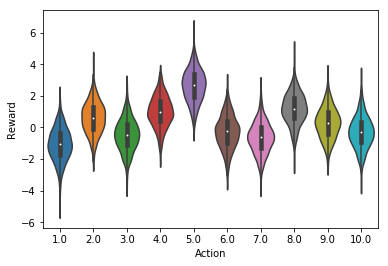

In [147]:
test_1 = EpsilonGreedy(epsilon = 0)
test_2 = EpsilonGreedy(epsilon = .01, q_initial = test_1.q_initial) #real values are the same for all tests
test_3 = EpsilonGreedy(epsilon = .1, q_initial = test_1.q_initial)

test_1.plot_true_values(1000)

In [149]:
show_time = True
stationary = True
steps = 10
iterations = 1
test_1.sample_average(steps = 10, iterations = 1, stationary = stationary, timer = show_time)
test_2.sample_average(steps = 10, iterations = 1, stationary = stationary, timer = show_time)
test_3.sample_average(steps = 10, iterations = 1, stationary = stationary, timer = show_time)

Run 1: 0.05 seconds
Elapsed time: 0.05 seconds
Run 1: 0.04 seconds
Elapsed time: 0.04 seconds
Run 1: 0.04 seconds
Elapsed time: 0.04 seconds


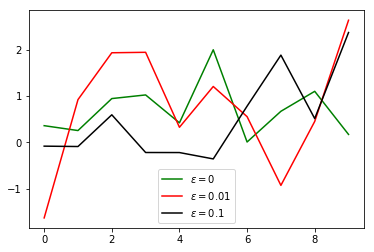

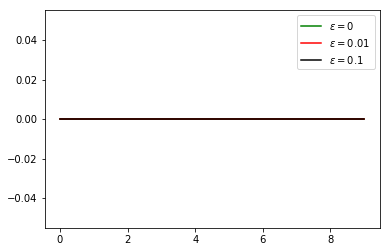

In [150]:
rwd_1 = np.mean(test_1.R_seq, axis = 1)
rwd_2 = np.mean(test_2.R_seq, axis = 1)
rwd_3 = np.mean(test_3.R_seq, axis = 1)

plt.figure()
plt.plot(rwd_1, 'g', label = r'$\epsilon = 0$')
plt.plot(rwd_2, 'r', label = r'$\epsilon = 0.01$')
plt.plot(rwd_3, 'k', label = r'$\epsilon = 0.1$')
plt.legend()

err_1 = np.mean(test_1.error, axis = 1)
err_2 = np.mean(test_2.error, axis = 1)
err_3 = np.mean(test_3.error, axis = 1)

plt.figure()
plt.plot(err_1, 'g', label = r'$\epsilon = 0$')
plt.plot(err_2, 'r', label = r'$\epsilon = 0.01$')
plt.plot(err_3, 'k', label = r'$\epsilon = 0.1$')
plt.legend()

### Exercise 2.3
$\epsilon = .01$ will perform better in the long run, since eventually it will explore every action and select the best one $99\%$ of the time.

## Nonstationary problem

Recall that the update formula for sample averages is:

$Q_{n+1} = Q_n + \frac{1}{n}\left(R_n - Q_n\right)$

This comes from a general rule of the form: $NewEstimate \rightarrow OldEstimate + StepSize \cdot (Target - OldEstimate)$. In the case of nonsationary problems is better to set the step size as a constant in order to give more weight to recent rewards and less to older ones. Thus, the equation is written:

$Q_{n+1} = Q_n+\alpha\left(R_n - Q_n\right) = \alpha R_n +(1-\alpha)Q_n$

Notice that in general, $\alpha = \alpha_n(a)$. Using the formula for $Q_n$ recursively yields:

$Q_{n+1} = (1-\alpha)^nQ_1+\sum_{i=1}^n\alpha(1-\alpha)^{n-1}R_i$

Which is a weighted average between $Q_1$ and $R_i$. Choosing $\alpha_t(a) = \frac{1}{n(a)}$ results in the sample-average method and the method converges (for great $n$). The conditions of convergence are:
$\sum_{n=1}^{\infty}\alpha_n(a) = \infty, \hspace{1cm}\sum_{n=1}^{\infty}\alpha_n^2(a) < \infty$

The first condition ensures that steps are large enough to overcome initial conditions. The second guarantees that steps will eventually be small enough to converge. The choice $\alpha_n(a) = \frac{1}{n}$ meets those conditions whereas $\alpha_n(a) = \alpha \in (0,1]$ does not because the second condition is never met, that is it will not converge, rather it will vary depending on recent rewards. However, this is desirable in a nonstationary problem, since the true values change in time. Besides, step sizes that meet convergence conditions are often very slow and therfore seldom used in practical terms.